# Classificação das imagens utilizando Vision Transformer (ViT)

## Arquitetura da Solução

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal



Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [1]:
!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
!unzip /content/covid-19-chest-x-ray.zip
!rm /content/covid-19-chest-x-ray.zip

Dataset URL: https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray
License(s): Apache 2.0
 99% 365M/369M [00:01<00:00, 174MB/s]
100% 369M/369M [00:02<00:00, 190MB/s]
Archive:  /content/covid-19-chest-x-ray.zip
replace Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Data.csv                
  inflating: Data/covid/100126173.png  
  inflating: Data/covid/101418710.jpg  
  inflating: Data/covid/10217856.png  
  inflating: Data/covid/102244181.jpeg  
  inflating: Data/covid/103445962.jpeg  
  inflating: Data/covid/104801348.jpeg  
  inflating: Data/covid/105435866.jpg  
  inflating: Data/covid/106531287.png  
  inflating: Data/covid/108711238.jpeg  
  inflating: Data/covid/11059951.png  
  inflating: Data/covid/111313983.png  
  inflating: Data/covid/112170361.jpeg  
  inflating: Data/covid/113381928.png  
  inflating: Data/covid/114316671.jpeg  
  inflating: Data/covid/115415399.png  
  inflating: Data/covid/116257521.jpeg  
  inflating: Data/covid/116310

## Imports

In [2]:
!pip install torch
!pip install torchinfo

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import random
import torch
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, ConcatDataset # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
from torchvision import datasets, transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import torchvision
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

mySeed = 42
np.random.seed(mySeed)
torch.manual_seed(mySeed)
torch.cuda.manual_seed(mySeed)

In [4]:
# selecionar a GPU caso exista
# ao selecionar a GPU, a tendencia é que o codigo seja executado mais rapidamente
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transfer-Learning

### O que é?

É a técnica de utilizar um modelo pré-treinado para outra tarefa, a fim de adaptá-lo para ser a base para um outro modelo.

Nesse caso, utilizaremos o modelo ViT_B_16 para realizar classificação do presente dataset.

Treinar um modelo "*from scratch*" tornaria a tarefa de classificação muito menos acertiva, uma vez que a base de dados é pequena para tal, assim como a disponibilidade de recursos computacionais para treiná-lo.

### Overview

Primeiramente, serão carregados os pesos do modelo pré-treinado ViT_B_16, dessa forma, será utilizada uma técnica de **Transfer Learning**.


In [5]:
pretrained_vit_w = torchvision.models.ViT_B_16_Weights.DEFAULT  # pesos pre-treinados ViT-Base

## Pré-processamento dos dados

Para garantir que as imagens estejam no formato correto e para melhorar o desempenho do modelo Vision Transformer (ViT), todas as imagens passaram por uma série de transformações de pré-processamento antes de serem usadas no treinamento e avaliação. As transformações aplicadas foram as seguintes:

```python
ImageClassification(
    crop_size=[224],
    resize_size=[256],
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    interpolation=InterpolationMode.BILINEAR
)
```
Tais transformações são definidas pelo modelo original ViT.

Detalhes das Transformações:
1. Resize: As imagens foram redimensionadas para 256x256 pixels. Esse redimensionamento garante que todas as imagens tenham um tamanho consistente antes de qualquer outra transformação ser aplicada.

2. Crop: Após o redimensionamento, um recorte central foi realizado para obter uma imagem de 224x224 pixels. Este tamanho é padrão para muitos modelos de visão computacional e é o tamanho de entrada esperado pelo modelo ViT.

3. Normalização:

* Mean: [0.485, 0.456, 0.406]
* Std: [0.229, 0.224, 0.225]


4. Interpolação: A interpolação bilinear (InterpolationMode.BILINEAR) foi usada durante o redimensionamento. Esse método de interpolação é geralmente eficaz para manter a qualidade visual das imagens ao redimensioná-las.

In [6]:
# Define a transformação a ser aplicada nas imagens
transform = pretrained_vit_w.transforms()

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
originalDataset = datasets.ImageFolder(root="/content/Data/", transform=transform)
flippedDataset = datasets.ImageFolder(root="/content/Data/", transform=transform2)
dataset = ConcatDataset([originalDataset, flippedDataset])

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.7
validation_ratio = 0.15
# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size
# Divide o dataset em conjuntos de treino e teste
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)


In [7]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de validacao
validation_class_count = {}

for _, label in validation_dataset:
    if label in validation_class_count:
        validation_class_count[label] += 1
    else:
        validation_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de validação
print(f'\nTamanho do conjunto de validação: {len(validation_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de teste
print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

Tamanho do conjunto de treino: 1674
Quantidade de imagens por classe no conjunto de treinamento:
Classe 2: 611 imagens
Classe 1: 647 imagens
Classe 0: 416 imagens

Tamanho do conjunto de validação: 358
Quantidade de imagens por classe no conjunto de validação:
Classe 2: 132 imagens
Classe 1: 136 imagens
Classe 0: 90 imagens

Tamanho do conjunto de teste: 360
Quantidade de imagens por classe no conjunto de teste:
Classe 2: 123 imagens
Classe 1: 153 imagens
Classe 0: 84 imagens


## Definindo nosso modelo + Fine-tune

Neste notebook, utilizamos o modelo Vision Transformer (ViT) para a classificação de imagens em três classes: `covid`, `normal` e `virus`. O modelo específico escolhido é o `vit_b_16`, que é uma variante base do Vision Transformer com patch size de 16.

### Pré-processamento das Imagens

As imagens utilizadas para o treinamento e avaliação foram redimensionadas e recortadas para o tamanho de 224x224 pixels. Este tamanho é padrão para muitos modelos de visão computacional e garante que todas as imagens de entrada sejam de dimensões consistentes.

### Classes de Imagens

As classes de saída para este problema de classificação são:
- `covid`
- `normal`
- `virus`

### Congelamento dos Pesos do Modelo

Para este projeto, utilizamos pesos pré-treinados no modelo ViT. Esses pesos foram obtidos de treinamentos prévios em grandes conjuntos de dados, como ImageNet. Congelamos esses pesos durante o treinamento para as seguintes razões:

1. **Preservar Conhecimento Prévio**: O modelo já possui conhecimento extraído de um vasto conjunto de dados. Congelar os pesos ajuda a manter esse conhecimento útil.
2. **Economizar Recursos Computacionais**: Atualizar todos os parâmetros do modelo é computacionalmente intensivo. Congelando os pesos, reduzimos a quantidade de computação necessária.
3. **Evitar Overfitting**: Quando o conjunto de dados de treinamento é relativamente pequeno, ajustar todos os parâmetros do modelo pode levar ao overfitting. Congelar os pesos ajuda a mitigar este risco.
4. **Foco nas Características Específicas**: Permitir que o modelo aprenda novas características específicas ao nosso conjunto de dados sem alterar as representações básicas já aprendidas.

### Etapas para Treinamento

O processo de treinamento foi dividido em duas etapas principais:
1. **Train**: Nesta etapa, o modelo foi treinado utilizando o conjunto de dados de treinamento, com ajustes realizados apenas nas camadas finais do modelo.
2. **Eval**: Na etapa de avaliação, o modelo foi avaliado utilizando um conjunto de dados de validação para medir seu desempenho e garantir que ele generaliza bem para novos dados.

Foi adicionado um mecanismo de early-stop: o treinamento será interrompido se não houver melhoria na métrica de validação por 2 épocas consecutivas.




In [8]:
pretrained_vit = torchvision.models.vit_b_16(    #utilizando o modelo-base, com os pesos padrao do modelo
    weights=pretrained_vit_w
    ).to(device)

class_names = originalDataset.classes #[covid, normal, virus]

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, #16x16x3 = 768
                                 out_features=len(class_names)
                                 ).to(device)
# Adicionado um dropout com probabilidade de 0.3 ao Encoder
pretrained_vit.encoder.dropout = nn.Dropout(p=0.3, inplace=True)

In [9]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Treino e Teste

In [10]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # colocar o modelo em modo de treinamento
    model.train()

    # inicializar valores com 0
    train_loss, train_acc = 0, 0

    # loop sobre os batches
    for batch, (X, y) in enumerate(dataloader):
        # enviar os dados para o device

        X, y = X.to(device), y.to(device)

        # forward
        y_pred = model(X)

        # calcular loss (e acumular)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # resetar o gradiente do otimizador antes do backpropagation
        optimizer.zero_grad()


        loss.backward()

        # ativar o otimizador
        optimizer.step()

        # calcular acuracia sobre os batches

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # ajustar as metricas para a media dos batches
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # coloca o modelo em modo eval
    model.eval()

    # iniciar valores com 0
    val_loss, val_acc = 0, 0

    # ligar inference context manager
    with torch.inference_mode():
        # loop sobre os batches
        for batch, (X, y) in enumerate(dataloader):
            # enviar os dados para o device
            X, y = X.to(device), y.to(device)

            # forward
            val_pred_logits = model(X)

            # calcular e "acumular" loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # calcular acuracia sobre os batches
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # ajustar as metricas para a media dos batches
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          eval_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          patience: int = 3) -> Dict[str, List]:

    # resultados
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    model.to(device)

    best_val_loss = float('inf')
    no_improvement_counter = 0

    # loop pelos passos de treino e teste de acordo com o numero de epocas definido
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=eval_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

        # Salva os resultados
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Verifica se a perda de validação atual é a melhor
        diff = val_loss - train_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_diff = diff
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        # Imprime os resultados para cada época
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Verifica se parar o treinamento devido ao early stopping
        if no_improvement_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            break

    return results


def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:

    model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            all_preds.append(y_pred)
            all_targets.append(y)

    # Concatena as predições e as classes
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return all_preds, all_targets

In [11]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      eval_dataloader=validation_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6231 | train_acc: 0.7717 | val_loss: 0.5996 | val_acc: 0.7222
Epoch: 2 | train_loss: 0.3996 | train_acc: 0.8874 | val_loss: 0.4141 | val_acc: 0.8429
Epoch: 3 | train_loss: 0.3313 | train_acc: 0.9073 | val_loss: 0.3826 | val_acc: 0.8611
Epoch: 4 | train_loss: 0.3005 | train_acc: 0.9061 | val_loss: 0.3205 | val_acc: 0.8681
Epoch: 5 | train_loss: 0.2737 | train_acc: 0.9163 | val_loss: 0.3153 | val_acc: 0.8602
Epoch: 6 | train_loss: 0.2554 | train_acc: 0.9156 | val_loss: 0.2980 | val_acc: 0.8785
Epoch: 7 | train_loss: 0.2387 | train_acc: 0.9346 | val_loss: 0.3157 | val_acc: 0.8767
Epoch: 8 | train_loss: 0.2295 | train_acc: 0.9333 | val_loss: 0.2726 | val_acc: 0.8837
Epoch: 9 | train_loss: 0.2137 | train_acc: 0.9331 | val_loss: 0.2580 | val_acc: 0.8889
Epoch: 10 | train_loss: 0.2246 | train_acc: 0.9303 | val_loss: 0.2741 | val_acc: 0.9028
Epoch: 11 | train_loss: 0.2203 | train_acc: 0.9268 | val_loss: 0.2365 | val_acc: 0.9045
Epoch: 12 | train_loss: 0.2093 | train_ac

## Resultados

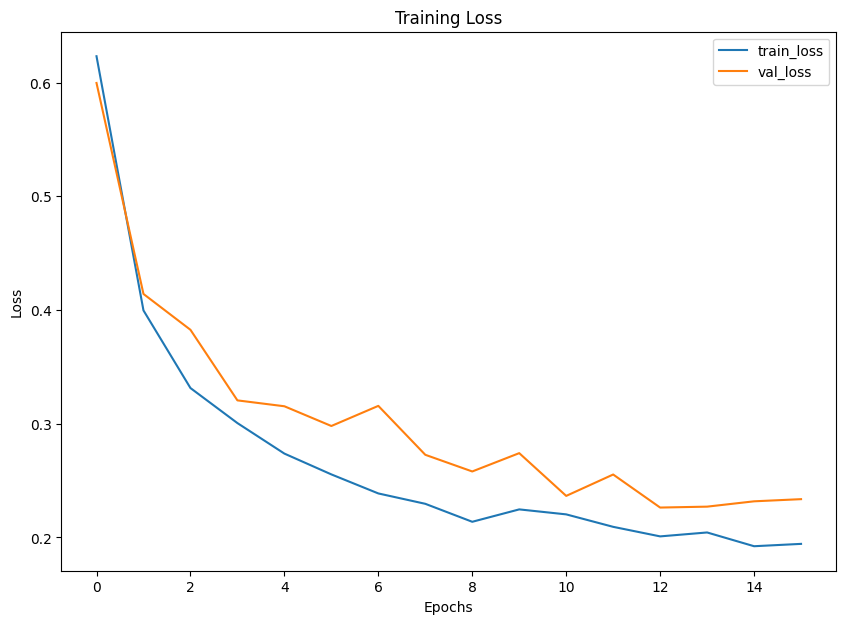

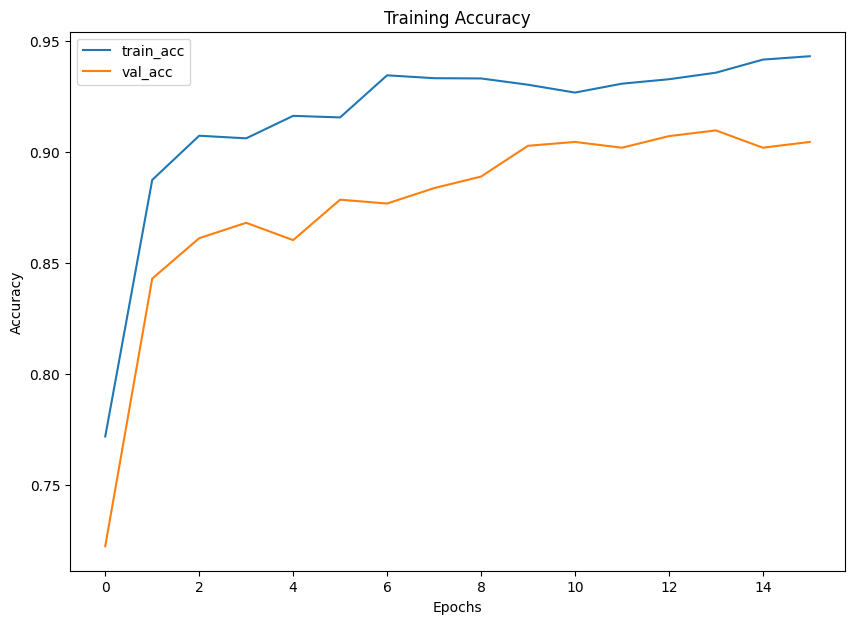

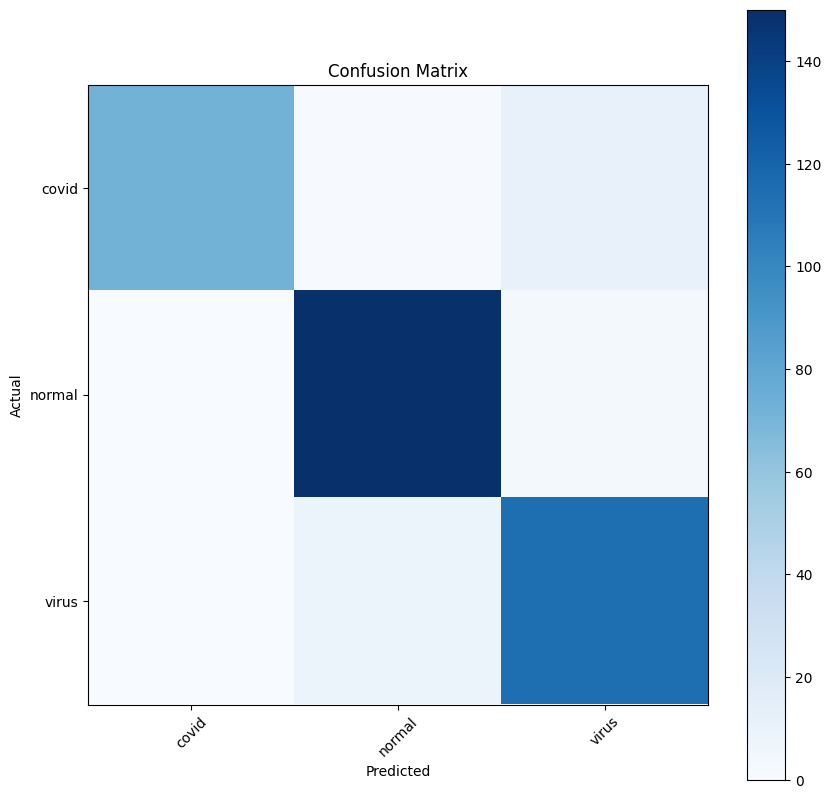

              precision    recall  f1-score   support

       covid       1.00      0.86      0.92        84
      normal       0.94      0.98      0.96       153
       virus       0.89      0.93      0.91       123

    accuracy                           0.93       360
   macro avg       0.94      0.92      0.93       360
weighted avg       0.94      0.93      0.93       360



In [12]:
## Avaliação do modelo

# Plota as métricas de treinamento
plt.figure(figsize=(10, 7))
plt.plot(pretrained_vit_results["train_loss"], label="train_loss")
plt.plot(pretrained_vit_results["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(pretrained_vit_results["train_acc"], label="train_acc")
plt.plot(pretrained_vit_results["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Realiza a predição no conjunto de teste
all_preds, all_targets = predict(model=pretrained_vit,
                                 dataloader=test_loader,
                                 device=device)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plota a matriz de confusão
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Imprime o classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))


O modelo foi avaliado utilizando várias métricas de desempenho, listadas acima. A precisão (precision) representa a proporção de verdadeiros positivos em relação ao total de previsões positivas, indicando quantas das previsões foram corretas. O recall mostra a capacidade do modelo de identificar todos os exemplos positivos, refletindo a proporção de verdadeiros positivos sobre a soma de verdadeiros positivos e falsos negativos. O f1-score é a média harmônica entre precisão e recall, oferecendo um balanço entre os dois. Para a classe 'covid', o modelo obteve uma precisão de 1.00, recall de 0.86 e f1-score de 0.92. A classe 'normal' teve uma precisão de 0.94, recall de 0.98 e f1-score de 0.96. Já para a classe 'virus', a precisão foi de 0.89, recall de 0.93 e f1-score de 0.91. A acurácia geral do modelo foi de 0.93, indicando que 93% das previsões estavam corretas. As médias macro e ponderada (macro avg e weighted avg) de precisão, recall e f1-score foram aproximadamente 0.94, 0.92 e 0.93, respectivamente, refletindo um desempenho consistente em todas as classes.